In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from conf.global_settings import OUTPUT_DIR
from utils.file_utils import get_date
from transformations.transformation import Transformation

In [2]:
ds_name = "RDEFT4"
hemisphere = ''
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.nc*')
if hemisphere:
    ds_granules = [g for g in ds_granules if hemisphere in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/RDEFT4/harvested_granules/2022/RDEFT4_20221031.nc


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')
ds = xr.open_dataset(sample_granule_path)
ds

<xarray.Dataset>
Dimensions:            (y: 448, x: 304)
Dimensions without coordinates: y, x
Data variables:
    sea_ice_thickness  (y, x) float32 ...
    snow_depth         (y, x) float32 ...
    snow_density       (y, x) float32 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
    freeboard          (y, x) float32 ...
    roughness          (y, x) float32 ...
    ice_con            (y, x) float32 ...
Attributes:
    Title:        NASA GSFC CryoSat-2 sea ice thickness and ancillary data
    Abstract:     This data set contains monthly averaged Arctic sea ice thic...
    Projection:   CryoSat-2 elevation data have a nominal footprint size of 3...
    Start_date:   20221002
    Start_time:   001113
    End_date:     20221031
    End_time:     235310
    Institution:  NASA Goddard Space Flight Center
    PI_name:      For questions related to this data set please contact the P...
    References:   A description of the primary methodology used in the retrie...

# Load grid

In [5]:
grids = glob(f'grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/grid_tpose6_radius.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
grid_ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation.Transformation(config, sample_granule_path, granule_date)

# Make mapping factors

In [8]:
factors = T.make_factors(grid_ds)

# Transformation

In [9]:
field_ds_list = T.transform(grid_ds, factors, ds, config)

In [10]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                                       (time: 1, tile: 13, j: 90,
                                                   i: 90, nv: 2)
Coordinates:
  * time                                          (time) datetime64[ns] 2022-...
  * tile                                          (tile) int16 0 1 2 ... 11 12
  * j                                             (j) int16 0 1 2 3 ... 87 88 89
  * i                                             (i) int16 0 1 2 3 ... 87 88 89
    XC                                            (tile, j, i) float32 -111.6...
    YC                                            (tile, j, i) float32 -88.24...
    time_bnds                                     (time, nv) datetime64[ns] 2...
Dimensions without coordinates: nv
Data variables:
    sea_ice_thickness_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       CryoSat-2 Level-4 Sea Ice Elevation, Freebo...
    original_dataset_short_name:  RDEFT4
    original_dataset_url:         https://nsidc.org/data/RDEFT4
    original_dataset_reference:   https://doi.org/10.5067/96JO0KIFDAS8
    original_dataset_doi:         10.5067/96JO0KIFDAS8
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.0
    notes:                        All saved filenames have the end date in th...

# Visualization

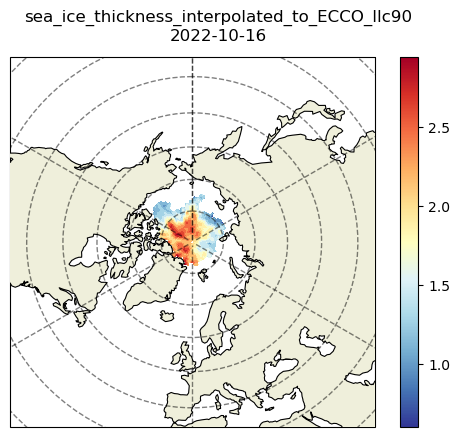

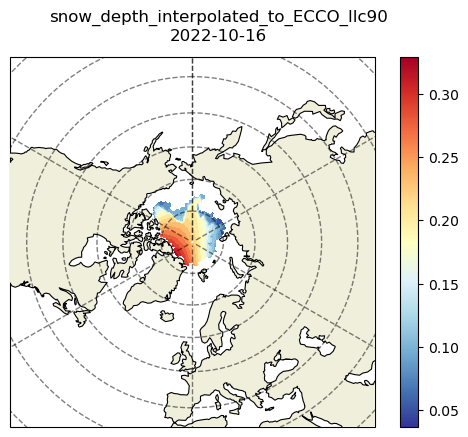

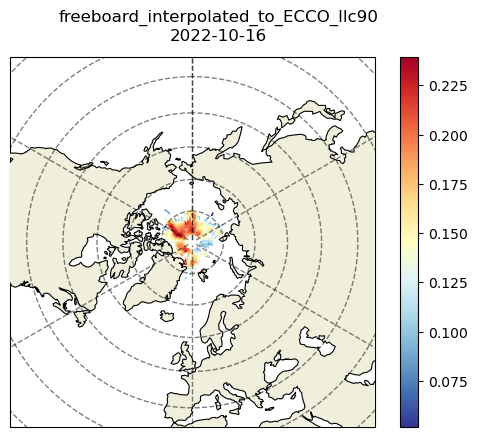

In [11]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
